## Exercise

For these exercises we'll perform a binary classification on the Census Income dataset available from the <a href = 'http://archive.ics.uci.edu/ml/datasets/Adult'>UC Irvine Machine Learning Repository</a><br>
The goal is to determine if an individual earns more than $50K based on a set of continuous and categorical variables.



### Census Income Dataset
For this exercises we're using the Census Income dataset available from the <a href='http://archive.ics.uci.edu/ml/datasets/Adult'>UC Irvine Machine Learning Repository</a>.

The full dataset has 48,842 entries. For this exercise we have reduced the number of records, fields and field entries, and have removed entries with null values. The file <strong>income.csv</strong> has	30,000 entries

Each entry contains the following information about an individual:
* <strong>age</strong>: the age of an individual as an integer from 18 to 90 (continuous)

* <strong>sex</strong>: Male or Female (categorical)
* <strong>education</strong>: represents the highest level of education achieved by an individual (categorical)
* <strong>education_num</strong>: represents education as an integer from 3 to 16 (categorical)
<div><table style="display: inline-block">
<tr><td>3</td><td>5th-6th</td><td>8</td><td>12th</td><td>13</td><td>Bachelors</td></tr>
<tr><td>4</td><td>7th-8th</td><td>9</td><td>HS-grad</td><td>14</td><td>Masters</td></tr>
<tr><td>5</td><td>9th</td><td>10</td><td>Some-college</td><td>15</td><td>Prof-school</td></tr>
<tr><td>6</td><td>10th</td><td>11</td><td>Assoc-voc</td><td>16</td><td>Doctorate</td></tr>
<tr><td>7</td><td>11th</td><td>12</td><td>Assoc-acdm</td></tr>
</table></div>


* <strong>marital-status</strong>: marital status of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Married</td><td>Divorced</td><td>Married-spouse-absent</td></tr>
<tr><td>Separated</td><td>Widowed</td><td>Never-married</td></tr>
</table></div>


* <strong>workclass</strong>: a general term to represent the employment status of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Local-gov</td><td>Private</td></tr>
<tr><td>State-gov</td><td>Self-emp</td></tr>
<tr><td>Federal-gov</td></tr>
</table></div>


* <strong>occupation</strong>: the general type of occupation of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Adm-clerical</td><td>Handlers-cleaners</td><td>Protective-serv</td></tr>
<tr><td>Craft-repair</td><td>Machine-op-inspct</td><td>Sales</td></tr>
<tr><td>Exec-managerial</td><td>Other-service</td><td>Tech-support</td></tr>
<tr><td>Farming-fishing</td><td>Prof-specialty</td><td>Transport-moving</td></tr>
</table></div>


* <strong>hours-per-week</strong>: the hours an individual has reported to work per week as an integer from 20 to 90 (continuous)

* <strong>income</strong>: whether or not an individual makes more than $50,000 annually (label)


* <strong>label</strong>: income represented as an integer (0: <= $50K, 1: >$50K) (optional label)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

### Exploarory data analysis

In [2]:
df = pd.read_csv("C:/Users/Lenovo/Desktop/Python/Deep Learning/Data Sets/PyTorch/income.csv")
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [3]:
df['label'].value_counts()

0    21700
1     8300
Name: label, dtype: int64

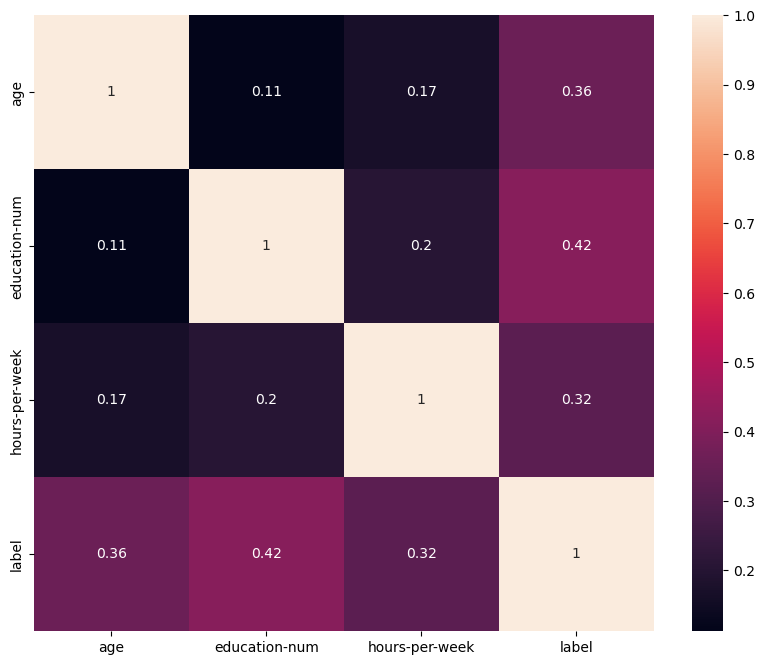

In [4]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

### Model
The implemented model demonstrates the capability to seamlessly handle both categorical and continuous variables. Leveraging this versatility, the data loader intelligently dissects the input data into distinct categories of categorical and continuous variables. Additionally, it dynamically calculates the embedding size, ensuring optimal utilization of resources and efficient representation of categorical data. This innovative approach empowers the model to efficiently process diverse types of input features, enhancing its flexibility and adaptability across various real-world scenarios.

#### Data Loader

In [5]:
class CustomDataLoader:
    def __init__(self, data, target, cat_cols=None, cont_cols=None, val_size=0.2, test_size=0.2, batch_size=2048):  
        self.batch_size = batch_size
        
        # Preprocess categorical variables 
        cats = []
        for cat in cat_cols:
            data[cat] = data[cat].astype('category')
            vec = data[cat].cat.codes.values
            cats.append(vec)
        cats = np.stack(cats, 1)
        
        cat_szs = [len(data[col].cat.categories) for col in cat_cols]
        self.emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
        
        # Preprocess continuous variables
        conts = []
        for con in cont_cols:
            vec = data[con].values
            conts.append(vec)
        conts = np.stack(conts, 1)

        # Concatenate categorical and continuous variables
        X = np.hstack((cats, conts))
        
        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, target.values, test_size=test_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=42)

        # Separate categorical and continuous variables
        self.cat_train, self.cat_val, self.cat_test = X_train[:, :cats.shape[1]], X_val[:, :cats.shape[1]], X_test[:, :cats.shape[1]]
        self.cont_train, self.cont_val, self.cont_test = X_train[:, cats.shape[1]:], X_val[:, cats.shape[1]:], X_test[:, cats.shape[1]:]
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test

    def get_data_loaders(self):
        # Combine categorical and continuous features with target into one TensorDataset
        train_dataset = TensorDataset(
            torch.tensor(self.cat_train, dtype=torch.long), 
            torch.tensor(self.cont_train, dtype=torch.float32),
            torch.tensor(self.y_train, dtype=torch.long))
        val_dataset = TensorDataset(
            torch.tensor(self.cat_val, dtype=torch.long), 
            torch.tensor(self.cont_val, dtype=torch.float32),
            torch.tensor(self.y_val, dtype=torch.long))
        test_dataset = TensorDataset(
            torch.tensor(self.cat_test, dtype=torch.long), 
            torch.tensor(self.cont_test, dtype=torch.float32),
            torch.tensor(self.y_test, dtype=torch.long))

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader



X = df.drop(columns=["label"])
y = df["label"]
cat_cols = ['sex', 'education-num', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
custom_loader = CustomDataLoader(X, y, cat_cols, cont_cols)
train_loader, val_loader, test_loader = custom_loader.get_data_loaders()

#### Neural Network 

In [6]:
class Model(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        y_pred = F.log_softmax(x, dim=1)
        return y_pred



# Define input and output sizes
model = Model(custom_loader.emb_szs, len(cont_cols), y.nunique(), [200, 100], p=0.4) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

### Training

Epoch 1/300, Train Loss: 0.8188, Test Loss: 0.7314
Epoch 2/300, Train Loss: 0.7178, Test Loss: 0.6965
Epoch 3/300, Train Loss: 0.6771, Test Loss: 0.6547
Epoch 4/300, Train Loss: 0.6365, Test Loss: 0.6181
Epoch 5/300, Train Loss: 0.6020, Test Loss: 0.5879
Epoch 6/300, Train Loss: 0.5736, Test Loss: 0.5624
Epoch 7/300, Train Loss: 0.5493, Test Loss: 0.5400
Epoch 8/300, Train Loss: 0.5272, Test Loss: 0.5191
Epoch 9/300, Train Loss: 0.5068, Test Loss: 0.4995
Epoch 10/300, Train Loss: 0.4875, Test Loss: 0.4808
Epoch 11/300, Train Loss: 0.4693, Test Loss: 0.4629
Epoch 12/300, Train Loss: 0.4521, Test Loss: 0.4460
Epoch 13/300, Train Loss: 0.4358, Test Loss: 0.4301
Epoch 14/300, Train Loss: 0.4207, Test Loss: 0.4152
Epoch 15/300, Train Loss: 0.4066, Test Loss: 0.4016
Epoch 16/300, Train Loss: 0.3938, Test Loss: 0.3891
Epoch 17/300, Train Loss: 0.3821, Test Loss: 0.3779
Epoch 18/300, Train Loss: 0.3717, Test Loss: 0.3679
Epoch 19/300, Train Loss: 0.3625, Test Loss: 0.3590
Epoch 20/300, Train L

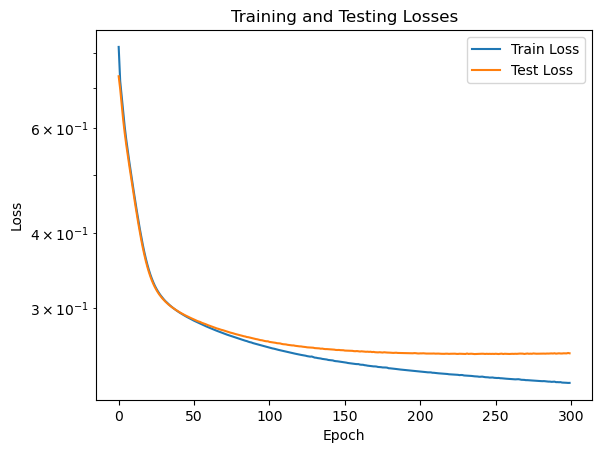

[[1211   75]
 [ 146  472]]


In [7]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def train(self, max_epochs):
        self.train_losses = []
        self.val_losses = []

        # Training
        for epoch in range(max_epochs):
            self.model.train
            train_loss = 0

            for cat_inputs, cont_inputs, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(cat_inputs, cont_inputs)
                loss = self.criterion(outputs.squeeze(), labels)  # Assuming output shape is [batch_size, 1]
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * cat_inputs.size(0)
            train_loss /= len(self.train_loader.dataset)
            self.train_losses.append(train_loss)

            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for cat_inputs, cont_inputs, labels in self.val_loader:
                    outputs = self.model(cat_inputs, cont_inputs)
                    loss = self.criterion(outputs.squeeze(), labels)
                    val_loss += loss.item() * cat_inputs.size(0)
                val_loss /= len(self.val_loader.dataset)
            self.val_losses.append(val_loss)

            if epoch % 1 == 0:
                print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}')
 
        return self.model
    
    def plot_losses(self, train_losses, test_losses):
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Set y-axis scale to logarithmic
        plt.title('Training and Testing Losses')
        plt.legend()
        plt.show()
    
    def evaluation(self, model, test_loader):
        model.eval()
        with torch.no_grad():
            for cat_inputs, cont_inputs, labels in test_loader:
                outputs = model(cat_inputs, cont_inputs)
                outputs = torch.max(outputs.squeeze(),1)[1]
        print(confusion_matrix(outputs.view(-1), labels.view(-1)))
            

trainer = Trainer(model, optimizer, criterion, train_loader, val_loader)   
model = trainer.train(300)      
trainer.plot_losses(trainer.train_losses, trainer.val_losses)
trainer.evaluation(model, test_loader)

### BONUS: Feed new data through the trained model
See if you can write a function that allows a user to input their own values, and generates a prediction.<br>
<strong>HINT</strong>:<br>There's no need to build a DataFrame. You can use inputs to populate column variables, convert them to embeddings with a context dictionary, and pass the embedded values directly into the tensor constructors:<br>
<pre>mar = input("What is the person's marital status? ")
mar_d = dict(Divorced=0, Married=1, Married-spouse-absent=2, Never-married=3, Separated=4, Widowed=5)
mar = mar_d[mar]
cats = torch.tensor([..., ..., mar, ..., ...], dtype=torch.int64).reshape(1,-1)</pre>
Make sure that names are put in alphabetical order before assigning numbers.

In [10]:
def test_data(mdl): # pass in the name of the model
    age = float(input("What is the person's age? (18-90)  "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edn = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    wrk = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hrs = float(input("How many hours/week are worked? (20-90)  "))

    sex_d = {'Female':0, 'Male':1}
    mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9, 
            'Tech-support':10, 'Transport-moving':11}

    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    # CREATE CAT AND CONT TENSORS
    cats = torch.tensor([sex,edn,mar,wrk,occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age,hrs], dtype=torch.float).reshape(1,-1)
    
    # SET MODEL TO EVAL (in case this hasn't been done)
    mdl.eval()

    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(cats, conts).argmax().item()

    print(f'\nThe predicted label is {z}')
    
test_data(model)


The predicted label is 0
